In [30]:
# BLOCK 1: Imports
import pandas as pd
import numpy as np
import os # CHANGED: Added 'os' for creating directories and managing file paths
import joblib # CHANGED: Added 'joblib' for saving the model and encoders
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import optuna

print("--- Data Loading and Preprocessing ---")

--- Data Loading and Preprocessing ---


In [31]:
# Block 2: Load and preprocess dataset
# Make sure to update the file path to where your dataset is located.
try:
    df = pd.read_csv(r"C:\Users\aruna\OneDrive\Desktop\Major-Pro\DATASET\Processed\cleaned_final_data.csv")
except FileNotFoundError:
    print("Error: Dataset file not found. Please update the path in Block 2.")
    exit()

# Remove missing target rows
df = df.dropna(subset=["current_value"])

# Log-transform target to stabilize outliers
df["current_value"] = np.log1p(df["current_value"])

# Clip extreme outliers at 99th percentile
clip_val = df["current_value"].quantile(0.99)
df["current_value"] = np.clip(df["current_value"], None, clip_val)

# Example engineered feature: Age Bucket
df["age_bucket"] = pd.cut(df["age"], bins=[0,20,25,30,35,100],
                        labels=["<20","20-25","25-30","30-35","35+"])

print("Dataset loaded and initial processing complete.")



Dataset loaded and initial processing complete.


In [32]:
# --- NEW BLOCK 2.5: Feature Engineering ---
#
# !! IMPORTANT !!
# This code assumes your dataset has columns named 'goals', 'assists', 
# 'appearances', 'team', and 'position'. 
#
# *** YOU MUST RENAME THEM IN THE CODE BELOW TO MATCH YOUR CSV FILE. ***
#
print("--- Starting Feature Engineering ---")

try:
    # 1. Create rate-based stats (handle division by zero if appearances = 0)
    # --- RENAME 'goals' AND 'appearances' IF YOUR NAMES ARE DIFFERENT ---
    df['goals_per_game'] = (df['goals'] / df['appearance']).fillna(0)
    df['assists_per_game'] = (df['assists'] / df['appearance']).fillna(0)

    # 2. Capture non-linear age effect (value peaks, then declines)
    # --- RENAME 'age' IF YOUR NAME IS DIFFERENT ---
    df['age_sq'] = df['age']**2
    
    # 3. Create aggregate "peer comparison" features
    # How does a player's goal count compare to their position's average?
    # --- RENAME 'position' AND 'goals' IF YOUR NAMES ARE DIFFERENT ---
    pos_avg_goals = df.groupby('position')['goals'].transform('mean')
    df['goals_vs_pos_avg'] = df['goals'] - pos_avg_goals
    
    # How does a player's goal count compare to their team's average?
    # --- RENAME 'team' AND 'goals' IF YOUR NAMES ARE DIFFERENT ---
    team_avg_goals = df.groupby('team')['goals'].transform('mean')
    df['goals_vs_team_avg'] = df['goals'] - team_avg_goals

    # Clean up any infinities or NaNs that might have been created
    # Only operate on numeric columns to avoid adding new categories to categoricals
    num_cols = df.select_dtypes(include=[np.number]).columns
    df[num_cols] = df[num_cols].replace([np.inf, -np.inf], 0).fillna(0)
    
    print(f"Engineered new features. New total features: {len(df.columns)}")

except KeyError as e:
    print(f"--- !!! ERROR in Feature Engineering !!! ---")
    print(f"Could not find column: {e}")
    print("Please RENAME the columns in 'NEW BLOCK 2.5' to match your CSV file.")
    print("Stopping execution to prevent errors.")
    # This will stop the notebook so you can fix the names
    raise e

--- Starting Feature Engineering ---
Engineered new features. New total features: 25


In [33]:
# Block 3: Label encode categorical variables and set Dtype
print("\n--- Encoding Categorical Variables ---")
cat_cols = ["team", "position", "age_bucket"]
encoders = {} 
for col in cat_cols:
    le = LabelEncoder()
    # Fit and transform
    df[col] = le.fit_transform(df[col].astype(str))
    
    # --- THIS IS THE NEW, ROBUST FIX ---
    # After encoding, convert the column to pandas' 'category' dtype
    # This is the most robust way to tell LightGBM what is a category
    df[col] = df[col].astype('category')
    # --- END NEW FIX ---
    
    encoders[col] = le
    print(f"Label encoded and set '{col}' to category dtype.")

# Features & target
X = df.drop(columns=["current_value"])
y = df["current_value"]


--- Encoding Categorical Variables ---
Label encoded and set 'team' to category dtype.
Label encoded and set 'position' to category dtype.
Label encoded and set 'age_bucket' to category dtype.


In [34]:
# Block 4: KFold for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [35]:
# Block 5: Baseline model score
print("\n--- Baseline Model Evaluation ---")
model = lgb.LGBMRegressor(random_state=42)
scores = cross_val_score(model, X, y, cv=kf, scoring="r2")
print(f"Baseline CV R²: {scores.mean()}")



--- Baseline Model Evaluation ---
Baseline CV R²: 0.5564299811826443
Baseline CV R²: 0.5564299811826443


In [36]:
# BLOCK 6: Hyperparameter tuning (MANUAL CV LOOP - Dtype Auto-detect)
print("\n--- Hyperparameter Tuning with Optuna (Manual CV Method) ---")

# We need KFold and r2_score for this block
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

def objective(trial):
    params = {
        "objective": "regression",
        "metric": "rmse",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "random_state": 42,
        "n_estimators": 2000, 
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 31, 256),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
    }
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    fold_scores = []
    
    for train_index, valid_index in kf.split(X, y):
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

        # --- THE FIX IS HERE ---
        # Create the model. We NO LONGER pass 'categorical_feature'.
        # LightGBM will auto-detect it from the 'category' dtype in Block 3.
        model = lgb.LGBMRegressor(**params)
        
        model.fit(
            X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            callbacks=[lgb.early_stopping(100, verbose=False)]
        )
        
        preds = model.predict(X_valid)
        score = r2_score(y_valid, preds)
        fold_scores.append(score)

    return np.mean(fold_scores)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=150, show_progress_bar=True) 
print(f"Best Params from Optuna: {study.best_params}")
print(f"Best CV R² from Optuna: {study.best_value}")

[I 2025-11-04 16:03:20,799] A new study created in memory with name: no-name-3a7d7772-0de0-4d29-954c-1ce76793a67a



--- Hyperparameter Tuning with Optuna (Manual CV Method) ---


  0%|          | 0/150 [00:00<?, ?it/s]

[I 2025-11-04 16:03:24,523] Trial 0 finished with value: 0.5662150152890251 and parameters: {'learning_rate': 0.022117978900705108, 'num_leaves': 74, 'max_depth': 10, 'min_child_samples': 47, 'subsample': 0.7655437343527474, 'colsample_bytree': 0.6542243356824751}. Best is trial 0 with value: 0.5662150152890251.
[I 2025-11-04 16:03:26,395] Trial 1 finished with value: 0.5639387819584968 and parameters: {'learning_rate': 0.05401301366637236, 'num_leaves': 246, 'max_depth': 5, 'min_child_samples': 22, 'subsample': 0.7589804518100915, 'colsample_bytree': 0.6372863023286733}. Best is trial 0 with value: 0.5662150152890251.
[I 2025-11-04 16:03:26,395] Trial 1 finished with value: 0.5639387819584968 and parameters: {'learning_rate': 0.05401301366637236, 'num_leaves': 246, 'max_depth': 5, 'min_child_samples': 22, 'subsample': 0.7589804518100915, 'colsample_bytree': 0.6372863023286733}. Best is trial 0 with value: 0.5662150152890251.
[I 2025-11-04 16:03:31,929] Trial 2 finished with value: 0.5

In [37]:
import matplotlib.pyplot as plt
lgb.plot_importance(final_model, max_num_features=20, figsize=(10, 8))
plt.show()

NameError: name 'final_model' is not defined

In [38]:
# Get predictions from your validation set
y_pred = final_model.predict(X_valid)

# It's better to plot the *actual values* (not the log-transformed ones)
actual_value = np.expm1(y_valid)
predicted_value = np.expm1(y_pred)

residuals = actual_value - predicted_value

plt.figure(figsize=(10, 6))
plt.scatter(actual_value, residuals)
plt.title("Residual Plot")
plt.xlabel("Actual Player Value (Euros)")
plt.ylabel("Error (Actual - Predicted)")
plt.axhline(0, color='red', linestyle='--')
plt.show()

NameError: name 'final_model' is not defined

In [ ]:
# BLOCK 7: Train the final model with best parameters
print("\n--- Training Final Model ---")
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

final_params = study.best_params
final_params['random_state'] = 42
final_params['n_estimators'] = 5000 
final_params['objective'] = 'regression'
final_params['metric'] = 'rmse'

# --- THE FIX IS HERE ---
# We NO LONGER pass 'categorical_feature'. It will be auto-detected.
final_model = lgb.LGBMRegressor(**final_params)

final_model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric="rmse",
    callbacks=[lgb.early_stopping(100, verbose=True)]
    # The 'categorical_feature' parameter is now gone
)

print(f"Final model trained. Best iteration: {final_model.best_iteration_}")

y_pred = final_model.predict(X_valid)
r2 = r2_score(y_valid, y_pred)
print(f"Final Model R² on Validation Set: {r2}")


--- Training Final Model ---
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1107]	valid_0's rmse: 1.60637
Early stopping, best iteration is:
[1107]	valid_0's rmse: 1.60637
Final model trained. Best iteration: 1107
Final Model R² on Validation Set: 0.5829597590989242
Final model trained. Best iteration: 1107
Final Model R² on Validation Set: 0.5829597590989242



--- Final Model Feature Importance ---
Saved feature importance plot to 'feature_importance.png'


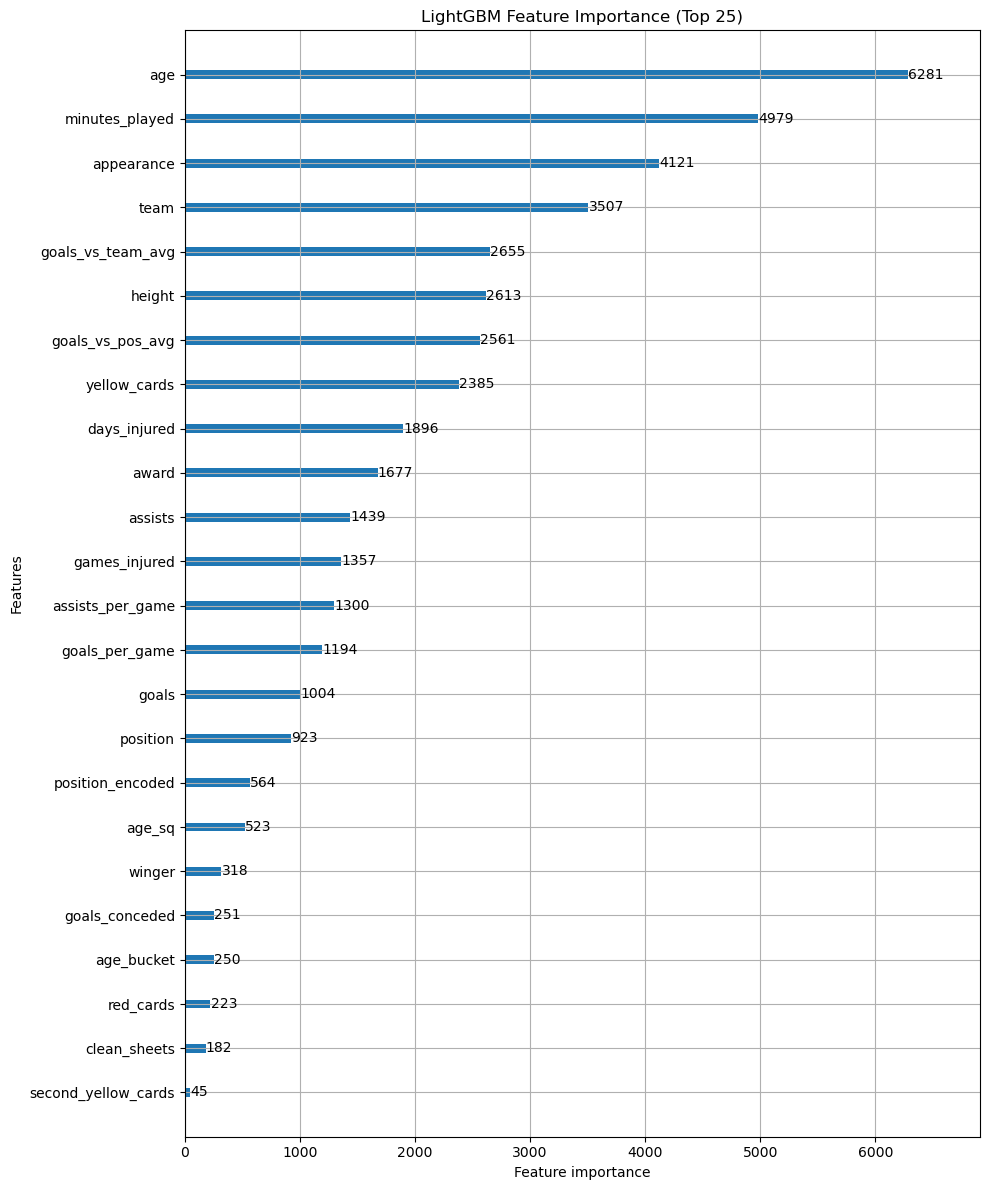

In [42]:
# --- NEW BLOCK 7.5: Analyze Final Model ---
import matplotlib.pyplot as plt

print("\n--- Final Model Feature Importance ---")

# Plot the top 25 features
lgb.plot_importance(
    final_model, 
    max_num_features=25, 
    figsize=(10, 12),
    title="LightGBM Feature Importance (Top 25)"
)
plt.tight_layout()
# Save the plot so you can see it
plt.savefig("feature_importance.png")
print("Saved feature importance plot to 'feature_importance.png'")

In [41]:
# BLOCK 8: Save the model and encoders
# CHANGED: This entire block is new. It handles saving the necessary files.
print("\n--- Saving Model and Encoders ---")

if not os.path.exists('models'):
    os.makedirs('models')
    print("Created 'models' directory.")

model_path = os.path.join('models', 'lgbm_model.pkl')
encoders_path = os.path.join('models', 'label_encoders.pkl')

joblib.dump(final_model, model_path)
print(f"Model saved to: {model_path}")

joblib.dump(encoders, encoders_path)
print(f"Encoders saved to: {encoders_path}")


--- Saving Model and Encoders ---
Model saved to: models\lgbm_model.pkl
Encoders saved to: models\label_encoders.pkl
